<a href="https://colab.research.google.com/github/mariojdepeine/mariojdepeine/blob/main/beermodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -Uqq fastbook

In [2]:
pip install streamlit

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '907b98cc07da408cb10c35ce9dd53581')


In [5]:
results = search_images_bing(key, 'Minoh Beer')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
beer_brands = 'Minoh Stout','hazy little things IPA can','chimay red bottle','hofbrau dunkel bottle','hofbrau maibock bottle','kapuziner weissbier can','big wave golden ale bottle','Suiyobi no neko','Chimay Blue','Asahi Super Dry','Aooni IPA','Inedit','Yona Yona Ale'
path = Path('beers')

if not path.exists():
    path.mkdir()
    for o in beer_brands:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} beer')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
fns = get_image_files(path)


In [8]:
failed = verify_images(fns)
failed.map(Path.unlink);

In [9]:
beers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = beers.dataloaders(path)

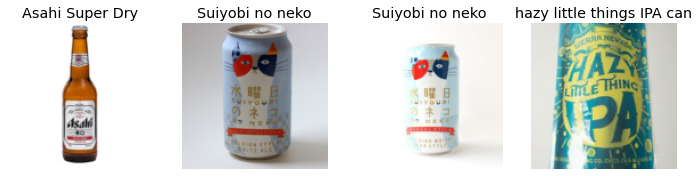

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)


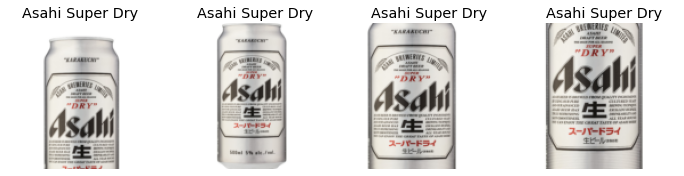

In [11]:
beers = beers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = beers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

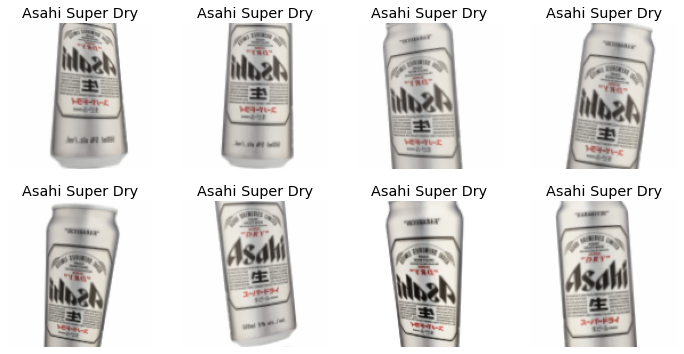

In [12]:
beers = beers.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = beers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
beers = beers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = beers.dataloaders(path)

In [28]:
learn = cnn_learner(dls, resnet152, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


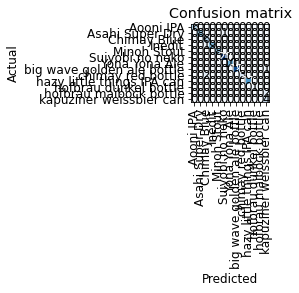

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

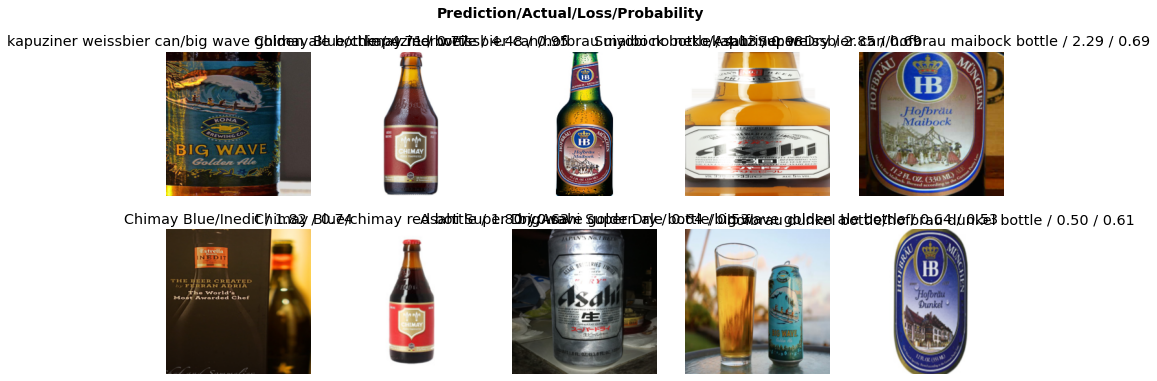

In [30]:
interp.plot_top_losses(10, nrows=2)

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [32]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [33]:
learn.export('beermodel.pkl')

In [64]:
path = Path()
path.ls(file_exts='.pkl')

(#3) [Path('beer.pkl'),Path('export.pkl'),Path('beermodel.pkl')]

In [65]:
path = Path()
learn_inf = load_learner(path/'beermodel.pkl')

In [66]:
learn_inf.dls.vocab

['Aooni IPA', 'Asahi Super Dry', 'Chimay Blue', 'Inedit', 'Minoh Stout', 'Suiyobi no neko', 'Yona Yona Ale', 'big wave golden ale bottle', 'chimay red bottle', 'hazy little things IPA can', 'hofbrau dunkel bottle', 'hofbrau maibock bottle', 'kapuziner weissbier can']

In [40]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [54]:
img = PILImage.create(btn_upload.data[-1])

In [55]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [56]:
pred,pred_idx,probs = learn_inf.predict(img)

In [57]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Suiyobi no neko; Probability: 0.5841')

In [58]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [61]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [67]:
VBox([widgets.Label('Select your beer!'), 
      btn_upload, btn_run, out_pl, lbl_pred])